In [108]:
data_location = 'sqlite:///../../../data/data.db'

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [110]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [111]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [112]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
tokens = ohlc.token.unique()

In [113]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

Additional features added(feature engineering):

In [120]:
colNames = ['ts', 'vol', 'ret', 'voluPct', 'ret3', 'ret6', 'ret12', 'ret24', 'vol3', 'vol12', 'voluPct3']
X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol = vol_ohlc(df).fillna(0),
            ret = df.close.pct_change(),
            voluPct = df.volumeUSD.pct_change(),
            ret3 = df.close.pct_change().rolling(3).mean(),
            ret6 = df.close.pct_change().rolling(6).mean(),
            ret12 = df.close.pct_change().rolling(6).mean(),
            ret24 = df.close.pct_change().rolling(24).mean(),
            vol3 = vol_ohlc(df).fillna(0).rolling(3).mean(),
            vol12 = vol_ohlc(df).fillna(0).rolling(12).mean(),
            voluPct3 = df.volumeUSD.pct_change().rolling(3).mean()
        )[colNames]
        .rename(columns={
            col: f'{col}_{token}' for col in colNames if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [121]:
X

,vol_BTC,ret_BTC,voluPct_BTC,ret3_BTC,ret6_BTC,ret12_BTC,ret24_BTC,vol3_BTC,vol12_BTC,voluPct3_BTC,...,vol_COMP,ret_COMP,voluPct_COMP,ret3_COMP,ret6_COMP,ret12_COMP,ret24_COMP,vol3_COMP,vol12_COMP,voluPct3_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 01:00:00,0.000000,0.004357,0.297514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,-0.002281,-0.407882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 02:00:00,0.000000,-0.004508,-0.053394,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,-0.006020,1.038275,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2021-11-01 03:00:00,0.000000,-0.012132,2.314383,-0.004095,NaN,NaN,NaN,0.000000,NaN,0.852834,...,0.000000,-0.022273,0.269205,-0.010191,NaN,NaN,NaN,0.000000,NaN,0.299866
2021-11-01 04:00:00,0.000000,-0.010186,-0.416218,-0.008942,NaN,NaN,NaN,0.000000,NaN,0.614924,...,0.000000,-0.024002,-0.346529,-0.017432,NaN,NaN,NaN,0.000000,NaN,0.320317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,0.136358,0.004810,0.096814,0.001101,-0.001061,-0.001061,0.000106,0.135499,0.120122,-0.112910,...,0.284268,0.006813,-0.288347,-0.007875,-0.004593,-0.004593,0.000792,0.279820,0.241217,0.199413
2021-12-14 21:00:00,0.142237,0.019797,1.110197,0.008336,0.001799,0.001799,0.001035,0.138334,0.121978,0.342276,...,0.281497,0.017473,2.932668,0.004286,-0.003830,-0.003830,0.001412,0.283998,0.245876,0.656138
2021-12-14 22:00:00,0.151148,0.010414,0.123041,0.011674,0.005123,0.005123,0.001318,0.143248,0.124634,0.443351,...,0.275083,0.009868,-0.130738,0.011385,0.000628,0.000628,0.001570,0.280283,0.249779,0.837861


In [122]:
X = X.dropna()
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]
assert(X.shape[0] == y.shape[0])

Autocorrelation check and correlation lookup:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

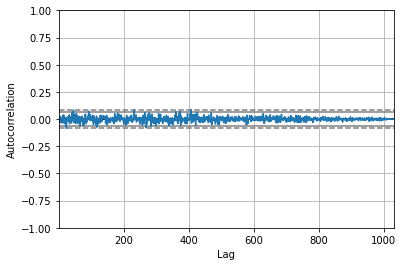

In [123]:
from pandas.plotting import scatter_matrix, autocorrelation_plot
autocorrelation_plot(y[1:])

In [124]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.0342101908437329,
 'ret_BTC': -0.007562936341408196,
 'voluPct_BTC': -0.04113719573547737,
 'ret3_BTC': -0.00942330723007947,
 'ret6_BTC': -0.007217400157406109,
 'ret12_BTC': -0.007217400157406109,
 'ret24_BTC': -0.03770077455019823,
 'vol3_BTC': 0.03968827966789314,
 'vol12_BTC': 0.031918992125785965,
 'voluPct3_BTC': 0.0009991945517195634,
 'vol_ETH': 0.030242556481733435,
 'ret_ETH': 0.0366802415555797,
 'voluPct_ETH': -0.046170336199225025,
 'ret3_ETH': 0.020228934256903384,
 'ret6_ETH': 0.012866438417984969,
 'ret12_ETH': 0.012866438417984969,
 'ret24_ETH': -0.02107631861545803,
 'vol3_ETH': 0.038056177589330345,
 'vol12_ETH': 0.02828483007995263,
 'voluPct3_ETH': 0.002201711600801519,
 'vol_USDT': 0.0076961940794045575,
 'ret_USDT': -0.04407376455750719,
 'voluPct_USDT': -0.042773593111501695,
 'ret3_USDT': -0.07006970124376556,
 'ret6_USDT': -0.0348556987340269,
 'ret12_USDT': -0.0348556987340269,
 'ret24_USDT': -0.046996037586271446,
 'vol3_USDT': 0.0061879074452

In [129]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer

#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [130]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [131]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

As you can see, with the feature expansion, the model now has a better score than (-0.008575141851714435).

In [133]:
pipeline = Pipeline([
    ('pca', PCA(n_components=10)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.008291379903542685